# Base models Latency

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
RESULTS_DIR = "../../results/"

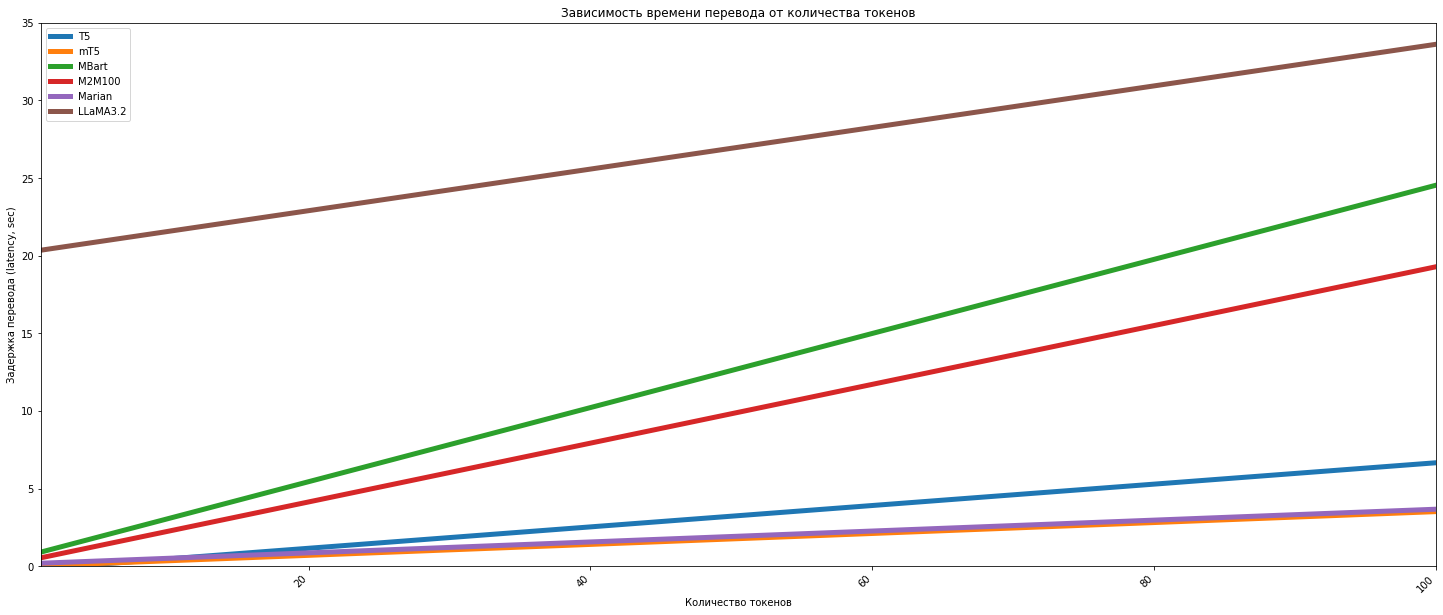

In [ ]:
plt.figure(figsize=(25,10)) # задание размера фигуры

models = {"T5": [0.06881, -0.20910],
          "mT5": [0.03518, 0.00808],
          "MBart": [0.23859, 0.68243],
          "M2M100": [0.18926, 0.36501],
          "Marian": [0.03513, 0.16822],
          "LLaMA3.2": [0.13391, 20.22426]
          }

x = np.linspace(1, 100)
# x = stats.index.to_numpy() # рассмотренные значения по оси x для линейного графика

for model in models.keys():
    a, b = models[model]
    y = a * x + b
    sns.lineplot(x=x, y=y, label=model, linewidth=5.0)

plt.axis([1, 100, 0, 35])
plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title("Зависимость времени перевода от количества токенов") # название фигуры
plt.xlabel("Количество токенов") # подпись по оси x
plt.ylabel("Задержка перевода (latency, sec)") # подпись по оси y
plt.legend() # отображение подписей графиков
plt.savefig(f"{RESULTS_DIR}latency_comparison_base_models.png", dpi="figure", bbox_inches="tight", transparent=False, facecolor="white") # сохранение графика
plt.show() # показ фигуры

# Pruned Latency

In [2]:
import json
import pandas as pd

import numpy as np # для работы с массивами
import matplotlib.pyplot as plt # для построения графиков
import seaborn as sns # для построения красивых графиков
import matplotlib.pyplot as plt

In [3]:
RESULTS_DIR = "../../results/"

In [31]:
models = {
    "Стандартная модель": "utrobinmv/t5_translate_en_ru_zh_small_1024",
    "Неструктурный прунинг, 20%": "t5_pruned_0.2_finetuned",
    "Неструктурный прунинг, 33%": "t5_pruned_0.33_finetuned",
    "Неструктурный прунинг, 50%": "t5_pruned_0.5_finetuned",
    "Структурный прунинг, 10%": "t5_pruned_structured_0.1_finetuned",
    "Структурный прунинг, 15%": "t5_pruned_structured_0.15_finetuned",
    "Структурный прунинг, 20%": "t5_pruned_structured_0.2_finetuned",
    "Структурный прунинг, 25%": "t5_pruned_structured_0.25_finetuned",
}

Стандартная модель: не учитываются при подсчёте 0 из 35246
Затрачиваемое время увеличивается, в среднем, на 0.03474 секунд за каждый новый токен, при этом модель работает не менее -0.08122 секунд.
Неструктурный прунинг, 20%: не учитываются при подсчёте 3 из 35289
Затрачиваемое время увеличивается, в среднем, на 0.02900 секунд за каждый новый токен, при этом модель работает не менее -0.02297 секунд.
Неструктурный прунинг, 33%: не учитываются при подсчёте 4 из 35289
Затрачиваемое время увеличивается, в среднем, на 0.02862 секунд за каждый новый токен, при этом модель работает не менее -0.01597 секунд.
Неструктурный прунинг, 50%: не учитываются при подсчёте 8 из 35289
Затрачиваемое время увеличивается, в среднем, на 0.03190 секунд за каждый новый токен, при этом модель работает не менее -0.02153 секунд.
Структурный прунинг, 10%: не учитываются при подсчёте 4 из 35289
Затрачиваемое время увеличивается, в среднем, на 0.04025 секунд за каждый новый токен, при этом модель работает не менее -0

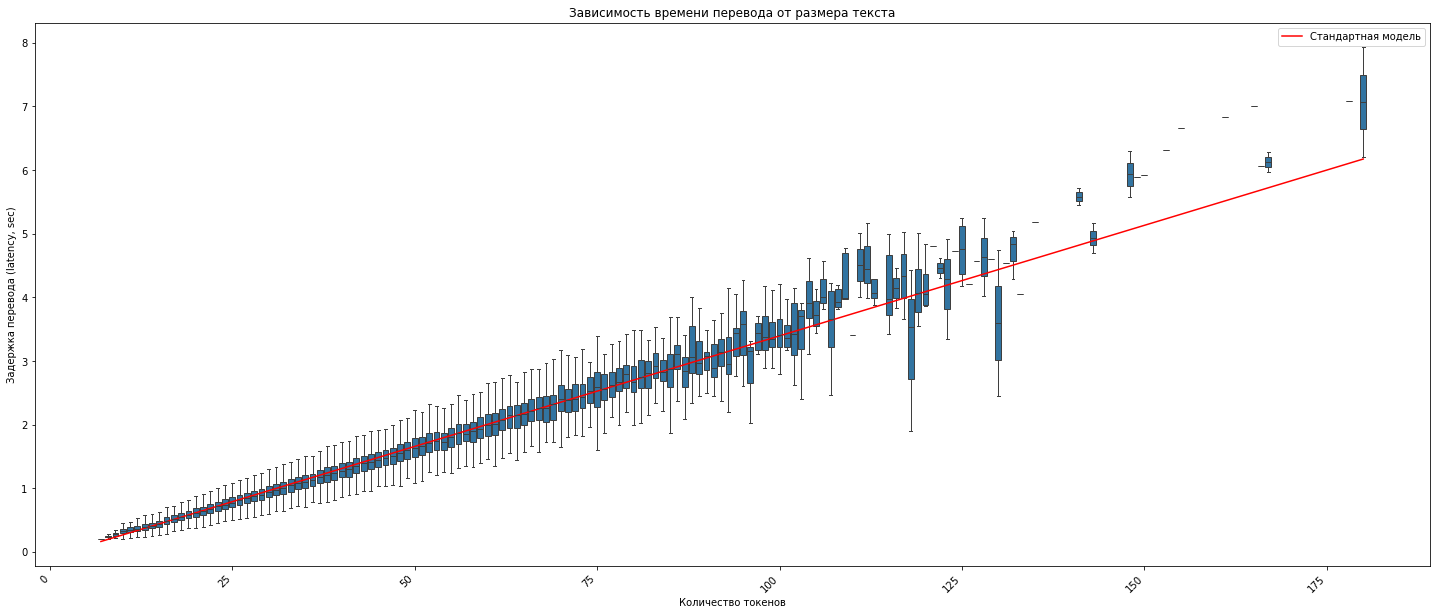

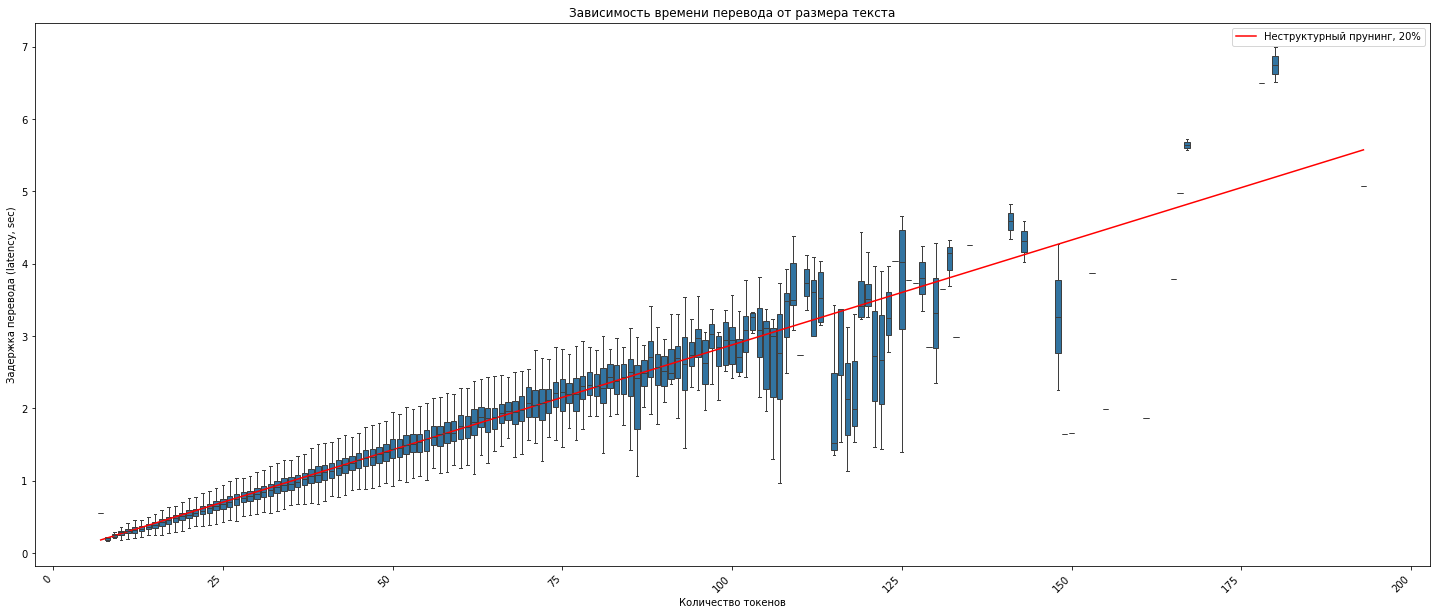

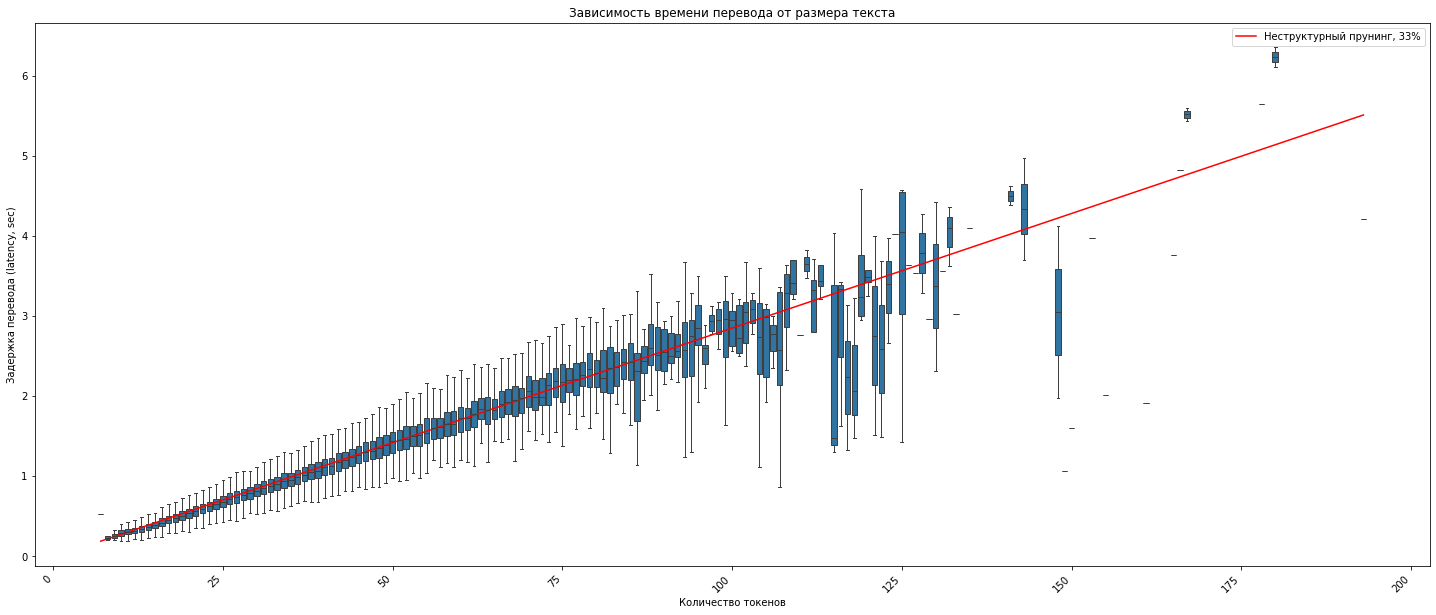

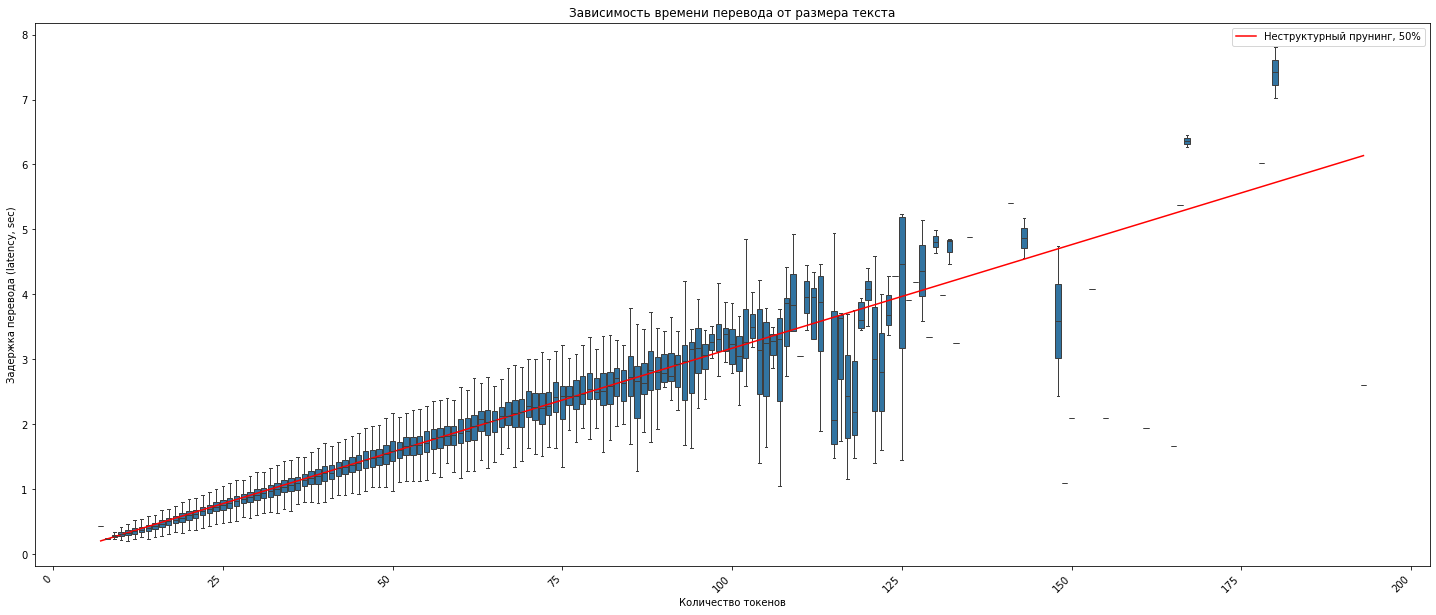

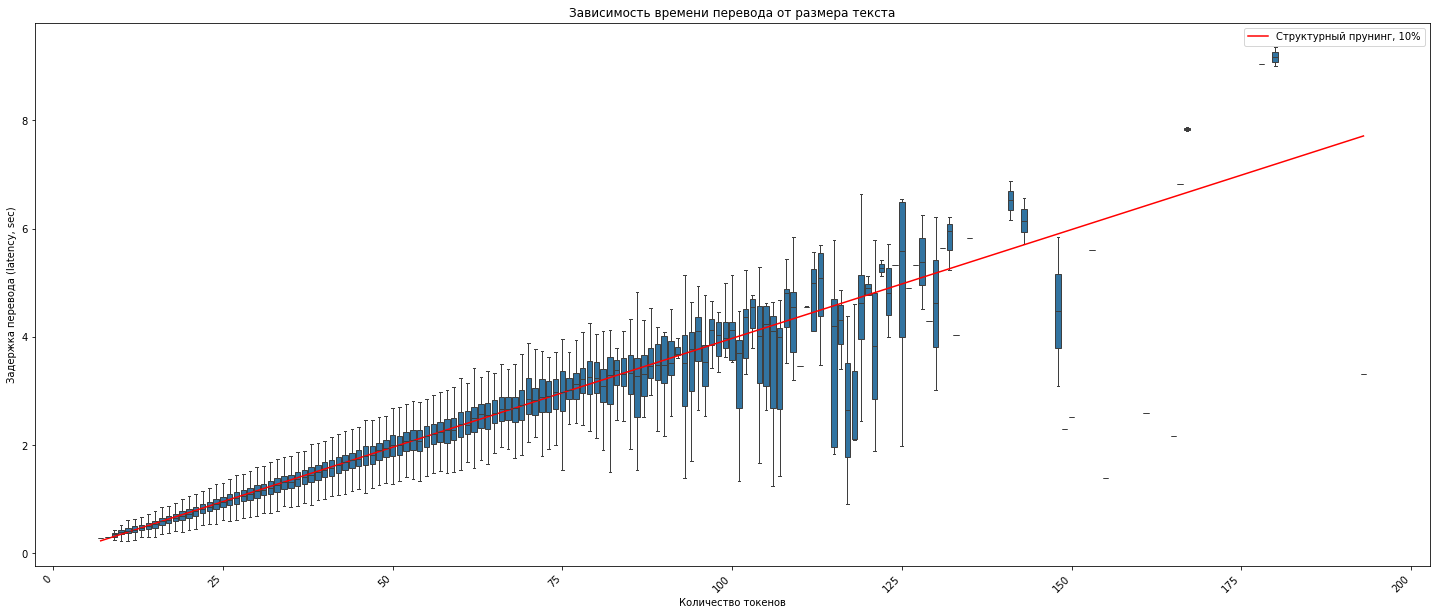

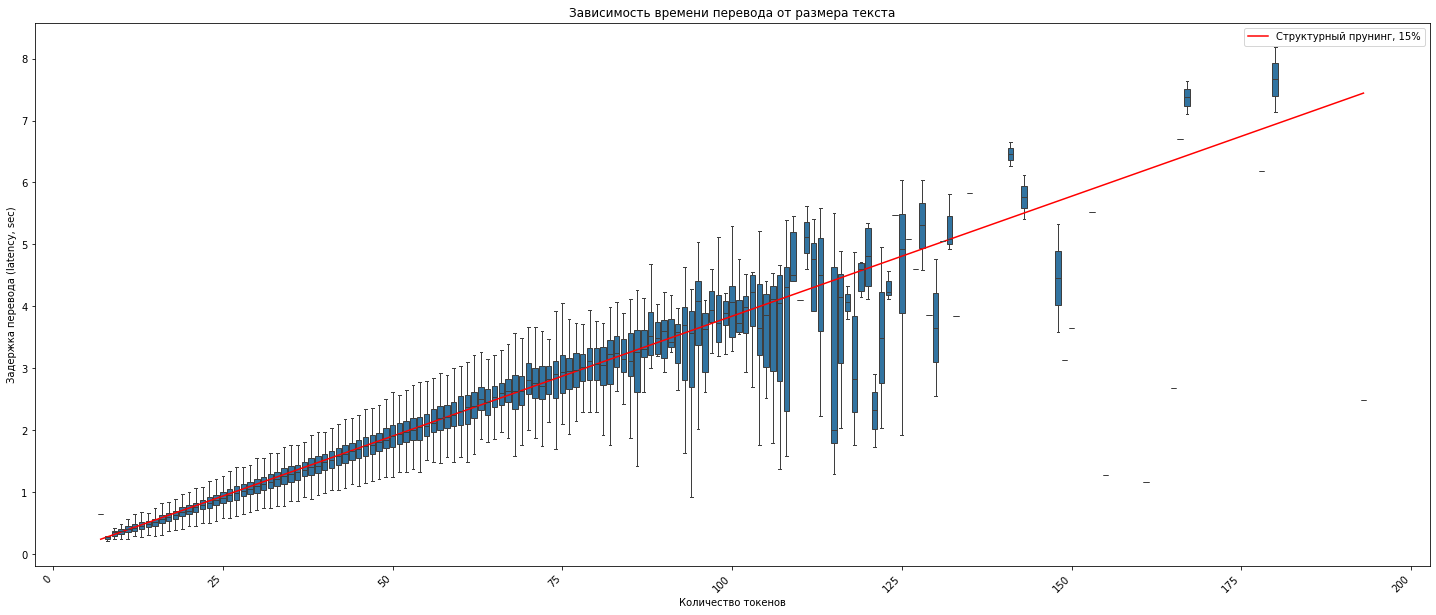

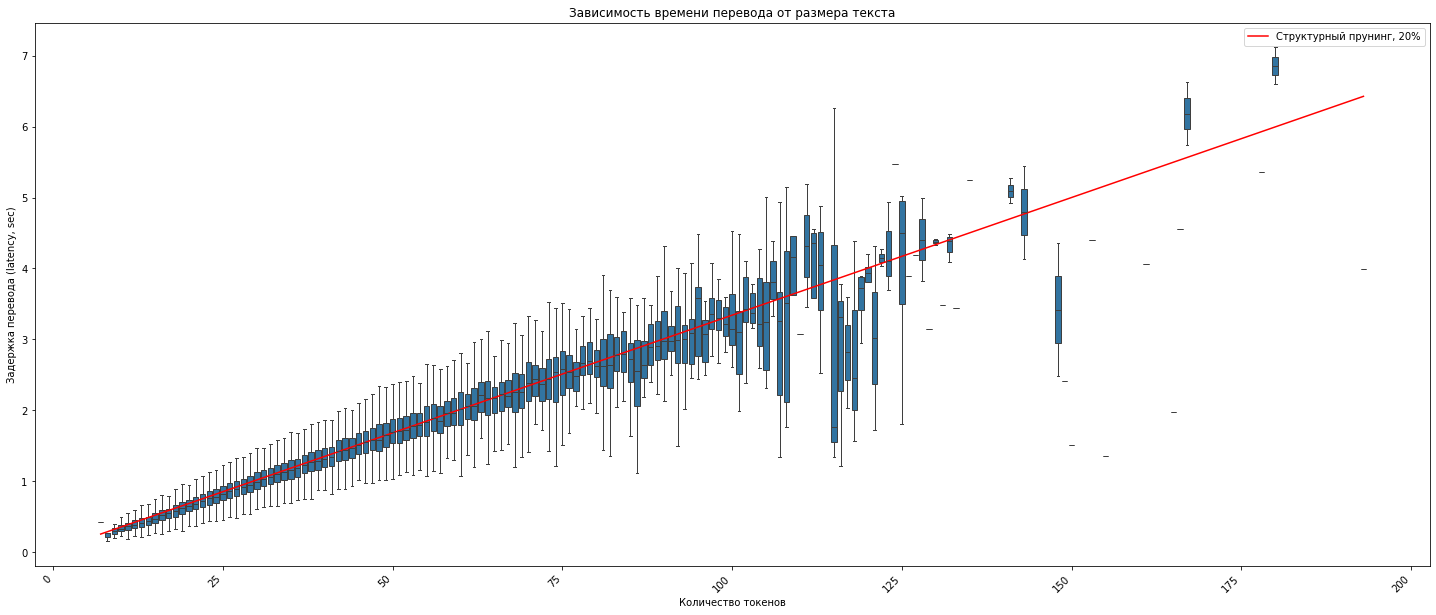

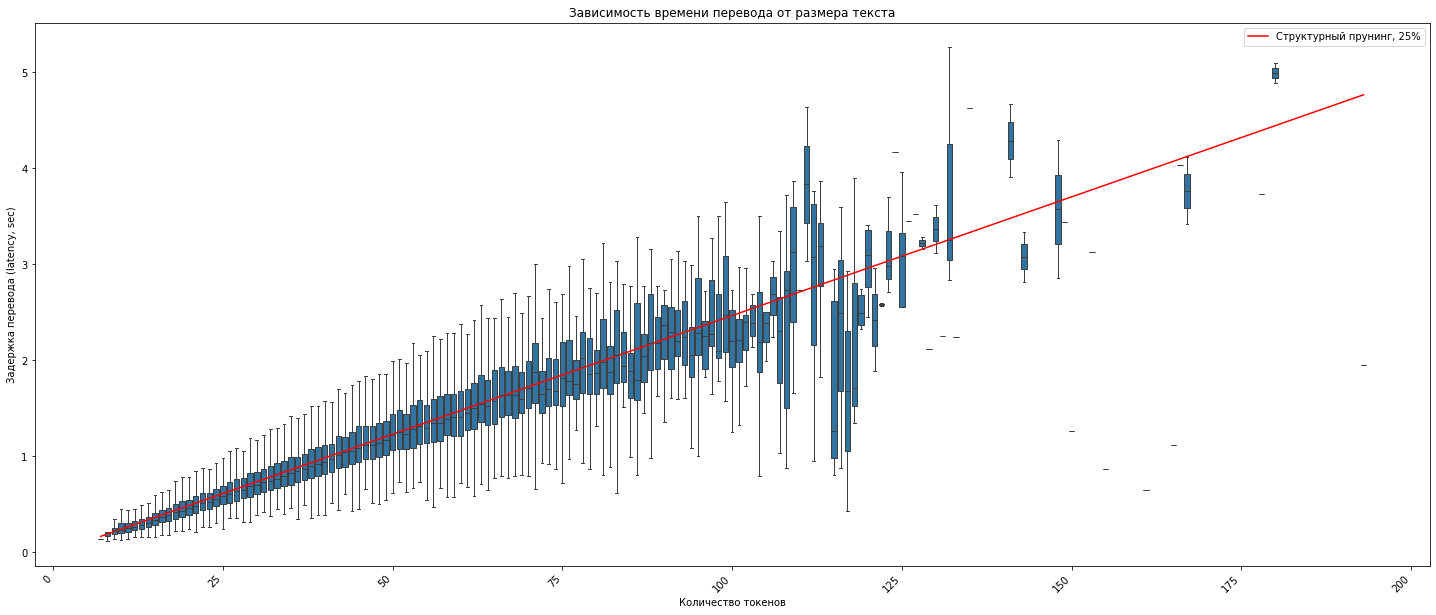

In [32]:
approximations = {}

for model in models.keys():
    MODEL_NAME = models[model]
    with open(RESULTS_DIR + MODEL_NAME + "/latency.json", "r") as f:
        latency = json.load(f)

    with open(RESULTS_DIR + MODEL_NAME + "/tokens_count.json", "r") as f:
        tokens_count = json.load(f)


    l_and_t = list(zip(latency, tokens_count))
    l_and_t_good = [obj for obj in l_and_t if (obj[0] < 15 and obj[1] < 200)]
    print(f"{model}: не учитываются при подсчёте {len(l_and_t) - len(l_and_t_good)} из {len(l_and_t)}")

    latency = [obj[0] for obj in l_and_t_good]
    tokens_count = [obj[1] for obj in l_and_t_good]


    results = pd.DataFrame({"Tokens count": tokens_count, "Latency": latency}) # собираем данные в DataFrame
    results.sort_values(by=["Tokens count"], inplace=True)
    results.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True - перезаписываем существующий датасет)

    stats = results.groupby(by="Tokens count", as_index=True).agg(mean=("Latency", "mean"),
                                                                std=("Latency", "std")
                                                                )

    outlier_indexes = []

    for index in results.index:
        tokens_count_, latency_ = results.loc[index]
        if np.abs(latency_ - stats.loc[tokens_count_]["mean"]) > 3 * stats.loc[tokens_count_]["std"]:
            outlier_indexes.append(index)

    results.drop(outlier_indexes, inplace=True)

    stats = results.groupby(by="Tokens count", as_index=True).agg(mean=("Latency", "mean"),
                                                                std=("Latency", "std")
                                                                )

    a, b = np.polyfit(stats.index[:75], stats["mean"][:75], deg=1) # считаем линейную аппроксимацию (deg=1), [:75] — так как после идёт большой разброс по времени из-за малой представленности в датасете
    print(f"Затрачиваемое время увеличивается, в среднем, на {a:.5f} секунд за каждый новый токен, при этом модель работает не менее {b:.5f} секунд.")




    plt.figure(figsize=(25,10)) # задание размера фигуры
    sns.boxplot(x=results["Tokens count"], y=results["Latency"], native_scale=True, showfliers=False) # строим "ящики с усами", showfliers — отображать ли выбросы, native_scale — воспринимать ли ось X как непрерывную (а не категориальную)

    x = np.linspace(stats.index[0], stats.index[-1])
    y = a * x + b
    approximations[model] = [a, b]

    sns.lineplot(x=x, y=y, color="red", label=f"{model}")

    plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
    plt.title("Зависимость времени перевода от размера текста") # название фигуры
    plt.xlabel("Количество токенов") # подпись по оси x
    plt.ylabel("Задержка перевода (latency, sec)") # подпись по оси y
    plt.legend() # отображение подписей графиков
    plt.savefig(f"{RESULTS_DIR}{MODEL_NAME}/latency_graph_limited.png", dpi="figure", bbox_inches="tight", transparent=False, facecolor="white") # сохранение графика
plt.show() # показ фигуры

In [35]:
colors = {
    "Стандартная модель": "#1240AB",
    "Неструктурный прунинг, 20%": "#FB000D",
    "Неструктурный прунинг, 33%": "#C7007D",
    "Неструктурный прунинг, 50%": "#FFB700",
    "Структурный прунинг, 10%": "#FFFC00",
    "Структурный прунинг, 15%": "#98ED00",
    "Структурный прунинг, 20%": "#600CAC",
    "Структурный прунинг, 25%": "#00A08A"
}

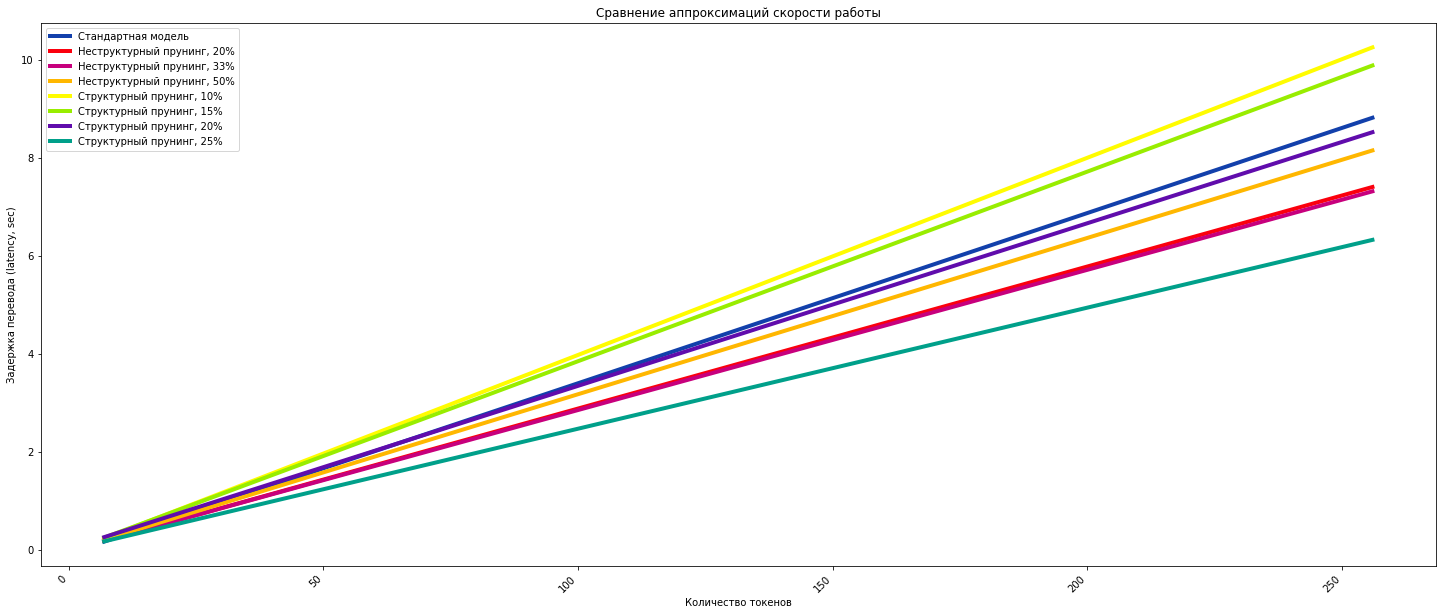

In [36]:
x = np.linspace(7, 256)

plt.figure(figsize=(25,10)) # задание размера фигуры

for model in approximations.keys():
    a = approximations[model][0]
    b = approximations[model][1]
    y = a * x + b

    sns.lineplot(x=x, y=y, label=f"{model}", linewidth=4.0, color=colors[model])

plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title("Сравнение аппроксимаций скорости работы") # название фигуры
plt.xlabel("Количество токенов") # подпись по оси x
plt.ylabel("Задержка перевода (latency, sec)") # подпись по оси y
plt.legend() # отображение подписей графиков
plt.savefig(f"{RESULTS_DIR}/latency_comparison_pruning.png", dpi="figure", bbox_inches="tight", transparent=False, facecolor="white") # сохранение графика
plt.show() # показ фигуры